# Molecular Dynamics (MD) Analysis and Visualization

## Table of Content <a name="TOC"></a>

1. [General setups](#setups)

2. [Reading MD trajectories and extracting info](#read_md) 

3. [Analysis of MD data](#analysis_of_md) 

  3.1. [Printing out](#3.1)
  
  3.2. [Compute descriptive statistics](#3.2)
  
  3.3. [Compute the probability distribution of the coordinates](#3.3)    

4. [Visualizing the MD data](#visualize_md) 

5. [Exercises](#exercises) 

### A. Learning objectives

- to read the xml files containing MD trajectories produced with Quantum Espresso (QE) package
- to extract and analyze the key information from MD - coordinates and velocities
- to visualize the MD trajectories 


### B. Use cases

- visualizing MD trajectories with py3Dmol
- analysis of Quantum Espresso results
- compute probability distribution functions

### C. Functions

- `libra_py`  
  - `QE_methods`
    - [`read_md_data`](#read_md_data-1)
    - [`read_md_data_cell`](#read_md_data_cell-1)  
  - `build`
    - [`make_xyz_mat`](#make_xyz_mat-1)

### D. Classes and class members

- `liblibra::libdata`
  - [`DATA`](#DATA-1)    
    - [`ave`](#ave-1)
    - [`var`](#var-1)
    - [`sd`](#sd-1)
    - [`se`](#se-1)
    - [`mse`](#mse-1)
    - [`mae`](#mae-1)
    - [`rmse`](#rmse-1)
    - [`min_val`](#min_val-1)
    - [`min_indx`](#min_indx-1)
    - [`max_val`](#max_val-1)
    - [`max_indx`](#max_indx-1)    
    - [`Calculate_Estimators`](#Calculate_Estimators-1)
    - [`Calculate_MiniMax`](#Calculate_MiniMax-1)
    - [`Calculate_Distribution`](#Calculate_Distribution-1)

## 1. General setups
<a name="reading_md"></a>[Back to TOC](#TOC)

In [1]:
from liblibra_core import *
from libra_py import QE_methods, build
import math
import py3Dmol

import matplotlib.pyplot as plt   # plots
%matplotlib inline 

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

/home/alexey/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::v

## 2. Reading MD trajectories and extracting info
<a name="reading_md"></a>[Back to TOC](#TOC)

Using the **QE_methods** module to read the trajectory data from an xml file produced by the QE package when running an MD calculation.

The function *read_md_data* extracts all the key information:
* R - coordinates
* V - velocities (determined from the coordinates, since QE doesn't give this info directly)
* A - accelerations (determined from the forces printed out by the QE)
* M - masses of all degrees of freedom
* E - labels of all atoms 

<a name="read_md_data-1"></a>

In [2]:
R, V, A, M, E = QE_methods.read_md_data("x0_co2.xml")

Note that all the variables R, V, A, and M are matrices with the dimensions ndof x nsteps (R, V, A) or ndof x 1 (M)

Here, ndof = 3 * natoms - the number of Cartesian degrees of freedom

nsteps - is the length of the MD trajectory

The variable E is a list of length natoms 

For our molecule, natoms = 3, so ndof = 9, so the matrices are of the form:

|   |   |   |   |
|---|---|---|---|
| $x_0(0)$  | $x_0(1)$  | ...  | $x_0(498)$ |
| $y_0(0)$  | $y_0(1)$  | ...  | $y_0(498)$ |
| $z_0(0)$  | $z_0(1)$  | ...  | $z_0(498)$ |
| $x_1(0)$  | $x_1(1)$  | ...  | $x_1(498)$ |
| $y_1(0)$  | $y_1(1)$  | ...  | $y_1(498)$ |
| $z_1(0)$  | $z_1(1)$  | ...  | $z_1(498)$ |
| $x_2(0)$  | $x_2(1)$  | ...  | $x_2(498)$ |
| $y_2(0)$  | $y_2(1)$  | ...  | $y_2(498)$ |
| $z_2(0)$  | $z_2(1)$  | ...  | $z_2(498)$ |

Note that subscript 0 corresponds to the first atom (C), 1 - to the second atom (O1), and 2 - to the last O atom
The numbers in the parenthesis indicate the MD time step


Lets check the dimensions and some content out

In [3]:
print("Dimensions of R are:", R.num_of_rows, R.num_of_cols)
print("Dimensions of V are:", V.num_of_rows, V.num_of_cols)
print("Dimensions of A are:", A.num_of_rows, A.num_of_cols)
print("Dimensions of M are:", M.num_of_rows, M.num_of_cols)
print("E = ",E)

Dimensions of R are: 9 499
Dimensions of V are: 9 499
Dimensions of A are: 9 499
Dimensions of M are: 9 1
E =  ['C', 'O', 'O']


Likevise, we can also extract the info about simulation cell
<a name="read_md_data_cell-1"></a>

In [4]:
C = QE_methods.read_md_data_cell("x0_co2.xml")

print("Vector a = ",  C.get(0,0), C.get(1,0), C.get(2,0) )
print("Vector b = ",  C.get(3,0), C.get(4,0), C.get(5,0) )
print("Vector c = ",  C.get(6,0), C.get(7,0), C.get(8,0) )


Vector a =  28.34589186938656 0.0 0.0
Vector b =  0.0 28.34589186938656 0.0
Vector c =  0.0 0.0 28.34589186938656


## 3. Analysis of MD data
<a name="analysis_of_md"></a>[Back to TOC](#TOC)

Now that we have actual data - coordinates, velocities, etc., we can do something fun with it

### 3.1. Printing out
<a name="3.1"></a>[Back to TOC](#TOC)

First, lets print out the coordinates of the O atoms for the first 5 steps of the MD (we don't want too much of the output here).

From the above, we know that these would be the atoms with indices 1 and 2, which would correspond to the degrees of freedom (DOF) 3, 4, and 5 (for atom 1) and 6, 7, 8 (for atom 2).

In [5]:
for i in range(5):
    
    # O1    
    print(F"Coordiantes of atom O1 at time step {i} x={ R.get(3, i) } y={ R.get(4, i)} z={ R.get(5, i)}")
    
    # O2    
    print(F"Coordiantes of atom O2 at time step {i} x={ R.get(6, i) } y={ R.get(7, i)} z={ R.get(8, i)}")    

Coordiantes of atom O1 at time step 0 x=2.4543092245540903 y=0.18868917162380944 z=7.666030829708675e-09
Coordiantes of atom O2 at time step 0 x=-2.454309656175175 y=0.188689205956003 z=2.2398148314508456e-08
Coordiantes of atom O1 at time step 1 x=2.445028904484351 y=0.18756287856756845 z=1.345094125450955e-08
Coordiantes of atom O2 at time step 1 x=-2.4450271753642276 y=0.18756274192559563 z=1.1076840380836335e-08
Coordiantes of atom O1 at time step 2 x=2.4266886424814635 y=0.1853394791561441 z=2.5817236096342832e-08
Coordiantes of atom O2 at time step 2 x=-2.4266822851405374 y=0.185338975895459 z=-5.3848885959511975e-08
Coordiantes of atom O1 at time step 3 x=2.399741342582681 y=0.18207751292656987 z=5.387658005582159e-08
Coordiantes of atom O2 at time step 3 x=-2.399731404947146 y=0.18207671762662436 z=-1.1563645970376355e-07
Coordiantes of atom O1 at time step 4 x=2.3649315429498934 y=0.17786566586902114 z=7.947838920976043e-08
Coordiantes of atom O2 at time step 4 x=-2.3649191189

### 3.2. Compute descriptive statistics
<a name="3.2"></a>[Back to TOC](#TOC)

Now, lets compute the average coordinates and standard deviation of each of the O atoms in the x direction. If we need, we can also access other statistical properties as well.

First, lets collect the data in Python lists. 

Note, at this point we can select which portion of data we want to include in the analysis. In particular, here we drop the first 10 steps of MD

In [6]:
x_list0 = []  # O1
x_list1 = []  # O2

for i in range(10, 500):        
    x_list0.append(R.get(3, i))  # O1 x coordinates        
    x_list1.append(R.get(6, i))  # O2 x coordinates

To get the desired statistical properties, we can use the methods of the Libra's **DATA** class, in particular the *Calculate_Estimators* function

After that, we can simply access the corresponding variables stored in the DATA objects
<a name="DATA-1"></a><a name="ave-1"></a><a name="var-1"></a><a name="sd-1"></a><a name="se-1"></a><a name="mse-1"></a><a name="mae-1"></a><a name="rmse-1"></a><a name="Calculate_Estimators-1"></a>

In [7]:
#print(x_list0, x_list1)
x0 = DATA(x_list0)
x1 = DATA(x_list1)

x0.Calculate_Estimators()
x1.Calculate_Estimators()

print("======= Estimators are ===========")
print( F"average of x:                     \t{x0.ave}\t{x1.ave}")
print( F"variance of x:                    \t{x0.var}\t{x1.var}")
print( F"sample standard deviation of x:   \t{x0.sd}\t{x1.sd}")
print( F"standard deviation of mean of x:  \t{x0.se}\t{x1.se}")
print( F"mean square error of x:           \t{x0.mse}\t{x1.mse}")
print( F"mean absolute error of x:         \t{x0.mae}\t{x1.mae}")
print( F"root mean square error of x:      \t{x0.rmse}\t{x1.rmse}")
  

======= Estimators are ===========
average of x:                     	2.225152888063258	-2.2243804331369597
variance of x:                    	0.02295726870759594	0.02638921712488615
sample standard deviation of x:   	0.1515165624860726	0.16244758269942386
standard deviation of mean of x:  	0.006844820581360196	0.007338633738839192
mean square error of x:           	0.022910417138804925	0.02633536157973332
mean absolute error of x:         	0.10652755662306577	0.10723772937465387
root mean square error of x:      	0.15136187478623844	0.16228173520064826


We can also compute the ranges of actual data - minimal and maximal values and to which data points they correspond.

For this, we use the *Calculate_MiniMax* function of the **DATA** class
<a name="Calculate_MiniMax-1"></a><a name="min_val-1"></a><a name="min_indx-1"></a><a name="max_val-1"></a><a name="max_indx-1"></a>

In [8]:
x0.Calculate_MiniMax()
x1.Calculate_MiniMax()

print( F"Minimal values of x are:            \t{x0.min_val}\t{x1.min_val}")
print( F"They occur at the timesteps:        \t{x0.min_indx}\t{x1.min_indx}")
print( F"Maximal values of x are:            \t{x0.max_val}\t{x1.max_val}")
print( F"They occur at the timesteps:        \t{x0.max_indx}\t{x1.max_indx}")


Minimal values of x are:            	0.18868917162380944	-2.454017807773589
They occur at the timesteps:        	489	183
Maximal values of x are:            	2.4539551996630036	0.188689205956003
They occur at the timesteps:        	184	489


### 3.3. Compute the probability distribution of the coordinates
<a name="3.3"></a>[Back to TOC](#TOC)

Before we can compute the probability density function (PDF), we need to determine the range of the x values we are interested in. To do this, we can simply re-use the min and max values computed above.

In [9]:
npts = 100

xmin, xmax = min([x0.min_val, x1.min_val]), max([x0.max_val, x1.max_val])
dx = ((xmax - xmin) / npts)

w = []
for i in range(npts):
    w.append(xmin + dx*i)

To compute required PDF, we use the *Calculate_Distribution* function of the **DATA** class. We call this function for each DATA object and pass the grid of interest as the argument.

The computed arrays (dens0 and dens1) contain the values of the PDF for each of the grid point. 

We can then plot the results with the matplotlib functions.
<a name="Calculate_Distribution-1"></a>

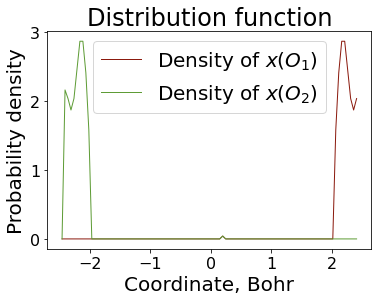

In [10]:
dens0, cum0 = x0.Calculate_Distribution(w)
dens1, cum1 = x1.Calculate_Distribution(w)


plt.title('Distribution function')
plt.xlabel('Coordinate, Bohr')
plt.ylabel('Probability density')
plt.plot(w, dens0, label='Density of $x(O_1)$', linewidth=1, color = colors["11"]) 
plt.plot(w, dens1, label='Density of $x(O_2)$', linewidth=1, color = colors["21"]) 
plt.legend()
plt.show()
plt.close()

## 4. Visualizing the MD data
<a name="visualize_md"></a>[Back to TOC](#TOC)

Unfortunately, the plain output format of QE is not supported by the high-quality visualising software such as VMD. 

The produced xml files can not be used so far. 

One route would of course be to convert the xml files into a plan xyz file and visualize it afterwards.

This can be done using the *make_xyz_mat* function of the **libra_py.build** module. The function takes the matrix of the coordinates to store (something you may have easily available in many situations when using Libra) and the corresponding atomic labels. This is all we really need to make an xyz file. 

As the result, the function returns a string that represent the xyz file.

Since we have already extracted atomic labels and coordinates from the QE xml file, we can use them in this funciton.
<a name="make_xyz_mat-1"></a>

In [11]:
xyz_file_content = build.make_xyz_mat(E,R)

f = open("co2.xyz", "w")
f.write(xyz_file_content)
f.close()

The convenience of the above *make_xyz_mat* function is also in the fact that it returns a string in the xyz file format. 

This string can be readily used to visualize the MD trajectory using **py3mol** Python library

In [12]:
view = py3Dmol.view(width=800,height=400, linked=False,viewergrid=(1,1))  
view.setBackgroundColor('0xeeeeee')                                     
view.zoomTo()                                                           
view.addModelsAsFrames(xyz_file_content, 'xyz', viewer=(0,0))
view.setStyle({'sphere':{'colorscheme':'Jmol', }})                        
view.animate({'reps':0, 'loop':'forward', 'step':1})
view.show()  

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 5. Exercises
<a name="exercises"></a>[Back to TOC](#TOC)

* Compute the fluctuation of the atoms in 3D
* Compute the velocity (absolute values and projections) distribution function

### 5.1. Quantify the fluctuations of C atom in 3D

In [13]:
R, V, A, M, E = QE_methods.read_md_data("x0_co2.xml")

cx, cy, cz = [], [], []
for i in range(10, 500):        
    cx.append(R.get(0, i))  
    cy.append(R.get(1, i))  
    cz.append(R.get(2, i))      
    
x, y, z = DATA(cx), DATA(cy), DATA(cz)
x.Calculate_Estimators()
y.Calculate_Estimators()
z.Calculate_Estimators()

sr = math.sqrt(x.sd**2 + y.sd**2 + z.sd**2)
print(F"3D fluctuation of the C atom is = {sr}")

3D fluctuation of the C atom is = 0.2861507681082132


### 5.2a. Compute the velocities distribution function (projections)

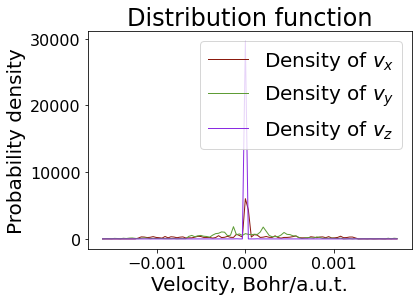

In [14]:
R, V, A, M, E = QE_methods.read_md_data("x0_co2.xml")
nat = len(E)

v_x, v_y, v_z = [], [], [] # velocities of all atoms
for i in range(10, 500):
    for at in range(nat):
        v_x.append(V.get(3*at+0, i))
        v_y.append(V.get(3*at+1, i))
        v_z.append(V.get(3*at+2, i))

vx, vy, vz = DATA(v_x), DATA(v_y), DATA(v_z)
vx.Calculate_MiniMax()
vy.Calculate_MiniMax()
vz.Calculate_MiniMax()


npts = 100
minv = min([vx.min_val, vy.min_val, vz.min_val])
maxv = max([vx.max_val, vy.max_val, vz.max_val])
dw = ((maxv - minv) / npts)

w = []
for i in range(npts):
    w.append(minv + dw*i)
    
dens_vx, cum_vx = vx.Calculate_Distribution(w)
dens_vy, cum_vy = vy.Calculate_Distribution(w)
dens_vz, cum_vz = vz.Calculate_Distribution(w)

plt.title('Distribution function')
plt.xlabel('Velocity, Bohr/a.u.t.')
plt.ylabel('Probability density')
plt.plot(w, dens_vx, label='Density of $v_x$', linewidth=1, color = colors["11"]) 
plt.plot(w, dens_vy, label='Density of $v_y$', linewidth=1, color = colors["21"]) 
plt.plot(w, dens_vz, label='Density of $v_z$', linewidth=1, color = colors["31"]) 
plt.legend()
plt.show()
plt.close()

### 5.2b. Compute the velocities distribution function (absolute values)

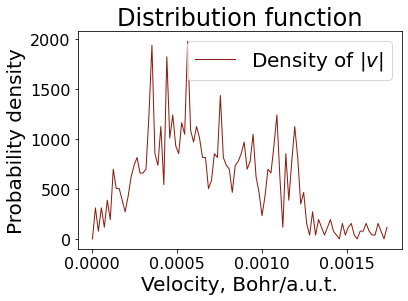

In [15]:
R, V, A, M, E = QE_methods.read_md_data("x0_co2.xml")
nat = len(E)

v_abs = [] # magnitudes of velocities of all atoms
for i in range(10, 500):
    for at in range(nat):
        vx = V.get(3*at+0, i)
        vy = V.get(3*at+1, i)
        vz = V.get(3*at+2, i)
        v_abs.append( math.sqrt(vx**2 + vy**2 + vz**2) )

v = DATA(v_abs)
v.Calculate_MiniMax()

npts = 100
minv = v.min_val
maxv = v.max_val
dw = ((maxv - minv) / npts)

w = []
for i in range(npts):
    w.append(minv + dw*i)
    
dens_v, cum_v = v.Calculate_Distribution(w)

plt.title('Distribution function')
plt.xlabel('Velocity, Bohr/a.u.t.')
plt.ylabel('Probability density')
plt.plot(w, dens_v, label='Density of $|v|$', linewidth=1, color = colors["11"]) 
plt.legend()
plt.show()
plt.close()